a. Bury Nicolas  
b. Student number: *
c. 31/01/2024

## <font color=crimson> 1.1 Exploratory Data Analysis

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> I start by importing and feeling the data, in order to get familiar with the content before going to the pre-processing step.
</div>

In [1]:
import pandas as pd
import numpy as np
import nltk

#I looked at the raw dataset before importing it to know what format is used, what/how many columns it contains & what seperator is used
df = pd.read_csv('tweet_emotions.csv',sep=',')
df = df.drop(columns=['tweet_id']) #I consider the 'tweet_id' is unecessary information (index) for my exercise and drop it
df = df.rename(columns={'content':'tweets'}) #I personally prefer calling the 'content' column 'tweets'

#I format both columns as string
df['sentiment'] = df['sentiment'].astype(str)
df['tweets'] = df['tweets'].astype(str)

#I display the data and show information
display(df.head())
print(df.info())

,sentiment,tweets
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  40000 non-null  object
 1   tweets     40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB
None


<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> My dataset consists of 2 columns only: 1 feature 'tweets' and the target 'sentiment' with 40.000 instances.
<br> This is, in text analytics, a supervised classification task aiming to predict the sentiment behind new tweets.
</div>

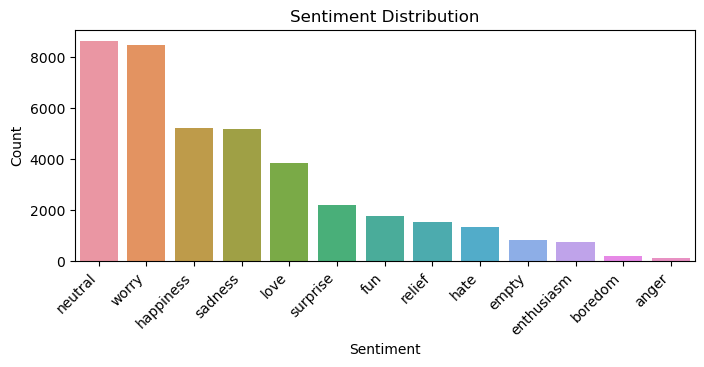

In [2]:
#I'll check what kind of sentiment we have and the class balance with a bar chart

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index) #I map the sentiment and sort for better readability
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> There is an expected important unbalance between the sentiments. I'll deal with that at a later stage (when modeling the data).
</div>

In [3]:
#There is a sentiment 'empty' which sounds odd. I'll check few instances to understand if it's a feeling or to be considered as 'blank' sentiment
display(df[df['sentiment'] == 'empty'].head(20))

,sentiment,tweets
0,empty,@tiffanylue i know i was listenin to bad habi...
44,empty,@creyes middle school and elem. High schools w...
52,empty,@djmicdamn hey yu lil fucker i textd yu
141,empty,@softtouchme just answered you- never learned ...
180,empty,Have a headache I'm going to bed. Goodnight!
203,empty,@DymeDiva23 Nite. Now I'm up n bored as oppose...
238,empty,"@TheTombert i was watching Harpers Island, lol..."
244,empty,@tarng Trudy's off Burnet...the one up north t...
272,empty,@msz_rockstar umm how bout em?..aint get 2 see...
339,empty,I need to be sleeping.. But i'm not even tired..


In [4]:
#It looks like 'empty' refers to blanks, as some tweets refer to being bored but are not identified as such.
#I also found a blank tweet with value 'O'.

print(len(df[df['tweets'] == '0'])) #to check how many '0' I have

4


In [5]:
#Considering I have 40.000 instances, I'll drop those 'empty' sentiments & '0' tweets'
df = df[df['tweets'] != '0']
print(f"Instances after removing '0': {len(df['tweets'])}")

df = df[df['sentiment'] != 'empty']
print(f"Instances after removing 'empty': {len(df['tweets'])}")

Instances after removing '0': 39996
Instances after removing 'empty': 39170


In [6]:
#In order to continue exploring the data, I need to convert my tweets into a nltk.Text object
#To do so, I'll concatenate all my tweets together and then word tokenize them.

from nltk.tokenize import word_tokenize
#nltk.download('punkt')

all_text = ' '.join(df['tweets']) #I concatenate all my tweets together
all_text = word_tokenize(all_text) #I tokenize by word
all_text = nltk.Text(all_text) #I convert to nltk.text object to check vocabulary

print("No of words: ", len(all_text))
print("Size of the vocabulary: ", len(all_text.vocab()))
print(all_text[:20])

No of words:  645864
Size of the vocabulary:  58204
['Layin', 'n', 'bed', 'with', 'a', 'headache', 'ughhhh', '...', 'waitin', 'on', 'your', 'call', '...', 'Funeral', 'ceremony', '...', 'gloomy', 'friday', '...', 'wants']


<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> Considering many words have typos, the vocabulary is quite poor in those tweets (compared to the Gutenberg corpus).
</div>

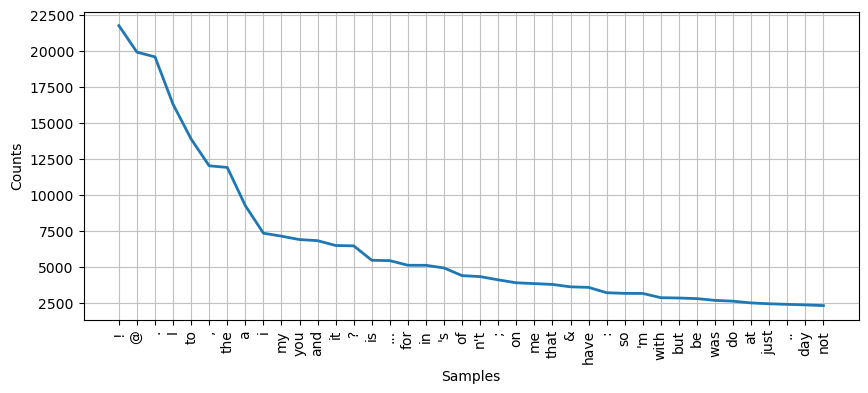

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [7]:
#I'll check the word frequency distribution by creating a plot. 
#This is important to highlight a potential word that might appear very frequently but have no value for the analysis (e.g. 'Twitter').
from nltk.probability import FreqDist

plt.figure(figsize=(10,4))
fdist = nltk.FreqDist(all_text)
fdist.plot(40, cumulative=False)

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> As expected, the most used words are stop words, especially symbols "!" very often used on tweets without real meaning, and symbol "@" to tag people.   
<br> It will be important to choose the right stop word removal strategy during the analysis phase, and consider getting rid of all tags.
</div>

In [8]:
#I'll explore the length of tweets as an additional feature, in case I can find a pattern (e.g. 'angry' tweets are usually longer)
df['length'] = df['tweets'].apply(len) #I add a feature which counts the len of each tweet
display(df.head())

,sentiment,tweets,length
1,sadness,Layin n bed with a headache ughhhh...waitin o...,60
2,sadness,Funeral ceremony...gloomy friday...,35
3,enthusiasm,wants to hang out with friends SOON!,36
4,neutral,@dannycastillo We want to trade with someone w...,86
5,worry,Re-pinging @ghostridah14: why didn't you go to...,84


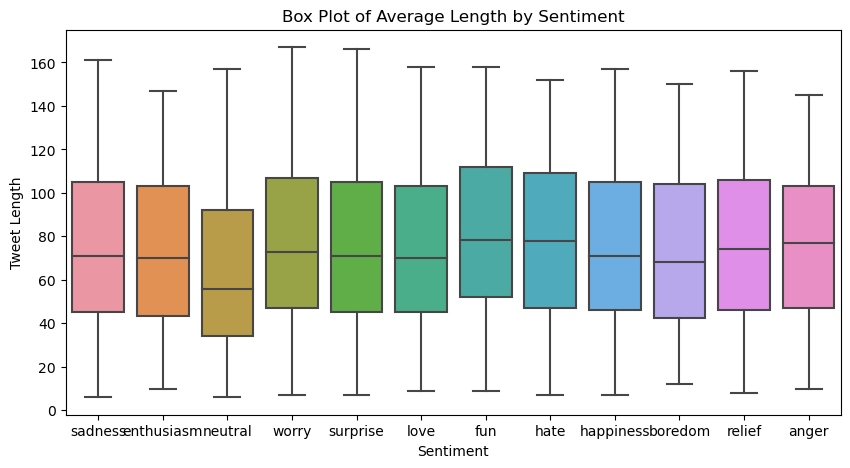

In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment', y='length', data=df)
plt.title('Box Plot of Average Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()

In [10]:
#Unfortunately I cannot find any pattern. All sentiments have similar dispersion and a lot of outliers.
#I'll drop this feature
df = df.drop(columns=['length'])

<div class="alert alert-warning" style="color: red; margin: 10px"><strong>Summary: 1.1. Exploratory Data Analysis</strong>
<br>
<br> A. Does the dataset you have been assigned have a specific class associated with the instances of the dataset? Can this be considered a classification problem, regression, or would clustering be a better choice?  
<br> -> Yes, there is a class called 'sentiment'. It is a supervised classification task aiming to predict the sentiment behind new tweets.
<br>
<br> B. Are there problems in the dataset? What other analysis can you think about? What about the features of the dataset, anything important to report? (Think about class balance, missing values, outliers, presence of multiple potential targets, interesting additional or potential analysis that may benefit the business) 
<br> -> There were a couple of problems:  
<br> - Class unbalance (will be treated in the next steps)
<br> - Missing values in the target ('empty' sentiment treated as blank)  
<br> - Big amount of stop word, especially '@' used to tag people in tweets. Those will have to be treated carefully in the next step.
<br>
<br> C. Explain your reasoning and use charting where appropriate. (Analyse with Python, compare, explain.). When charting, try to build a story around the charts that would justify the data analysis that you are going to perform.
<br> -> I have used and interpreted charts around class balance, word frequency & tweets length.
<br>
<br> D. In this exploratory analysis you should also explain any other potential secondary analysis that may have business value and should be performed on this data set.
<br> -> There are various secondary analysis we could do using this dataset:
<br> - Analyze sentiment within a specific topic or theme
<br> - Explore temporal patterns in sentiment (even without timestamp being available, tweets are sorted by IDs so I assume by insert time)
<br> - Identify users with consistenly positive sentiments (could be influencers or brand advocates)
<br> - Identify users with consistenly negative sentiments (risk management, to avoid escalation into crisis)
</div>

## <font color=crimson> 1.2 Data Analysis

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> Now that I have explored the data, I will dive into the pre-processing to get ready to vectorize the dataset and then train the models.
<br> I've done some research on how to pre-process tweets considerig the nature of the language and the structure.
<br> Benefit of POS tagging will be limited, as tweets are rather short and informal.
<br>
<br> I've decided to go for the following operations:
<br>- Word Tokenize the tweets
<br>- Normalize the tweets (lower case & remove punctuation)
<br>- Remove Stop Words
<br>- Treat Tags (I'm not sure if it's better to keep or remove. I'll start by removing, and review later based on models performance)
<br>- Apply Stemming
</div>

<div class="alert alert-warning" style="color: red; margin: 10px"><strong>A. Add or select a label/target to the document corpus you have been provided and explain why you selected those labels/targets.</strong>
<br> -> I've selected the sentiment as this is a supervised classification task aiming to predict sentiment of new tweets.
</div>

<div class="alert alert-warning" style="color: red; margin: 10px"><strong>B. Apply the word to vector necessary transformations (stop word removal, tokenization, TF-IDF, word frequencies...) . Explain your approach.</strong>
<br> -> In the section below, I'll get the data ready to get vectorized.
</div>

In [11]:
#I start by splitting my dataset into train & test to avoid overfitting my models.
from sklearn.model_selection import train_test_split

X = df.drop(columns=['sentiment']) #define the feature
y = df.drop(columns=['tweets']) #define the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split dataset with random state

In [12]:
#Now I'll tokenize my training feature
#I've done some research to find best way to tokenize the hashtags and found out there is a specific Tweet tokenizer in NLTK library
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer() #I create the tokenizer
X_train['tweets'] = X_train['tweets'].apply(tknzr.tokenize) #I apply the tokenizer
display(X_train.head(10)) #I do a visual check

,tweets
39136,"[happy, mother's, day, to, all, your, mom's]"
26588,"[Its, raining, cats, and, dogs, here, ,, in, M..."
23889,"[finally, Mike, 0hh, ', s, birthday, <3, can't..."
4636,"[Good, Morning, ., It's, Friday, and, the, sta..."
37594,"[barely, awake, ,, eating, breakfast, .., mara..."
21451,"[@breadesign, Congratulations, chap, !, Pass, ..."
36934,"[I, will, not, be, late, ., I, will, not, be, ..."
30387,"[@fancyfantastic, you, know, I, love, you, .]"
18845,"[my, finger, is, now, pregnant]"
25576,"[@samueltwitt1, You, don't, get, that, from, M..."


In [13]:
#I'll normalize my training feature
X_train['tweets'] = X_train['tweets'].apply(lambda tokens: [token.lower() for token in tokens]) #lowercase

X_train['tweets'] = X_train['tweets'].apply(lambda tokens: [token for token in tokens if token.isalpha() or (token.endswith('s') and len(token) > 1)])
#I've done research to ensure I keep words finishing with "'s" when removing punctuation
#With this method, I also remove all the people tags in the tweets

display(X_train.head(10))

,tweets
39136,"[happy, mother's, day, to, all, your, mom's]"
26588,"[its, raining, cats, and, dogs, here, in, myso..."
23889,"[finally, mike, s, birthday, wait, to, fucking..."
4636,"[good, morning, it's, friday, and, the, start,..."
37594,"[barely, awake, eating, breakfast, marathon, m..."
21451,"[congratulations, chap, pass, on, our, love, t..."
36934,"[i, will, not, be, late, i, will, not, be, lat..."
30387,"[you, know, i, love, you]"
18845,"[my, finger, is, now, pregnant]"
25576,"[you, get, that, from, marcus, i, must, say]"


In [14]:
#I'll now remove stop words from my training feature
#nltk.download('stopwords') #downloaded
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) #defining what set of stop word to use
X_train['tweets'] = X_train['tweets'].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])

display(X_train.head(10))

,tweets
39136,"[happy, mother's, day, mom's]"
26588,"[raining, cats, dogs, mysore, thankfully, pigs..."
23889,"[finally, mike, birthday, wait, fucking, ruin]"
4636,"[good, morning, friday, start, work, week, lak..."
37594,"[barely, awake, eating, breakfast, marathon, m..."
21451,"[congratulations, chap, pass, love, claude]"
36934,"[late, late, late]"
30387,"[know, love]"
18845,"[finger, pregnant]"
25576,"[get, marcus, must, say]"


In [15]:
#I'll now do the stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer() #create the stemmer
X_train['tweets'] = X_train['tweets'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

display(X_train.head(10))

,tweets
39136,"[happi, mother', day, mom']"
26588,"[rain, cat, dog, mysor, thank, pig, swine]"
23889,"[final, mike, birthday, wait, fuck, ruin]"
4636,"[good, morn, friday, start, work, week, laker,..."
37594,"[bare, awak, eat, breakfast, marathon, morn, g..."
21451,"[congratul, chap, pass, love, claud]"
36934,"[late, late, late]"
30387,"[know, love]"
18845,"[finger, pregnant]"
25576,"[get, marcu, must, say]"


In [16]:
#I'll remove the "'" from my words
X_train['tweets'] = X_train['tweets'].apply(lambda tokens: [token.replace("'", "") for token in tokens])
display(X_train.head(10))

,tweets
39136,"[happi, mother, day, mom]"
26588,"[rain, cat, dog, mysor, thank, pig, swine]"
23889,"[final, mike, birthday, wait, fuck, ruin]"
4636,"[good, morn, friday, start, work, week, laker,..."
37594,"[bare, awak, eat, breakfast, marathon, morn, g..."
21451,"[congratul, chap, pass, love, claud]"
36934,"[late, late, late]"
30387,"[know, love]"
18845,"[finger, pregnant]"
25576,"[get, marcu, must, say]"


In [17]:
# I join the pre-processed tokens back into strings which is required for vectorization
X_train['tweets'] = X_train['tweets'].apply(lambda tokens: ' '.join(tokens))
display(X_train.head(10))

,tweets
39136,happi mother day mom
26588,rain cat dog mysor thank pig swine
23889,final mike birthday wait fuck ruin
4636,good morn friday start work week laker go take...
37594,bare awak eat breakfast marathon morn good luc...
21451,congratul chap pass love claud
36934,late late late
30387,know love
18845,finger pregnant
25576,get marcu must say


<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> I consider my tweets are pre-processed and ready to get vectorized
<br> I've had some challenges around tags and words finishing with "'s", I took the simple & fast solution for both.
<br> I will see how the models perform, and keep this in the back of my mind.
</div>

In [18]:
#I'll create a function with all the pre-process steps above so I can apply it easier on my test set.

def preprocess(text):
    #1
    tokens = tknzr.tokenize(text)
    
    #2
    tokens = [token.lower() for token in tokens]
    
    #3
    tokens = [token for token in tokens if token.isalpha() or (token.endswith('s') and len(token) > 1)]
    
    #4
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    
    #5
    tokens = [stemmer.stem(token) for token in tokens]
    
    #6
    tokens = [token.replace("'", "") for token in tokens]
    
    #7
    processed_text = ' '.join(tokens)
    
    return processed_text

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> I have 2 options for vectorization: Count Vectorization or TF-IDF.
<br> Count Vectorization is simple and captures frequency of words in documents.
<br> TF-IDF considers importance of words accross documents but is more complex and requires large dataset.
<br> 
<br> I'll try to use TF-IDF, considering the quantity of data I have.    
</div>

In [19]:
#Before vectorizing, I have to address class unbalance
#I'll start by visualising the balance in my training set
display(y_train['sentiment'].value_counts())

neutral       5977
worry         5896
happiness     3719
sadness       3655
love          2702
surprise      1524
fun           1254
relief        1054
hate           903
enthusiasm     541
boredom        115
anger           79
Name: sentiment, dtype: int64

In [20]:
#I've decided to oversample the minorty class, as we have some categories with very low amount of data.
#It would have big impact to undersample and lose so much data.
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42) #I create the oversampler
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
display(y_resampled['sentiment'].value_counts()) #I do a visual check

neutral       5977
happiness     5977
fun           5977
love          5977
relief        5977
surprise      5977
sadness       5977
worry         5977
hate          5977
enthusiasm    5977
anger         5977
boredom       5977
Name: sentiment, dtype: int64

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer() # I create my TF-IDF Vectorizer
X_train_tfidf = tfidf_vectorizer.fit_transform(X_resampled['tweets'])

print("TF-IDF Vectorized Shape:", X_train_tfidf.shape) #I do a visual check

TF-IDF Vectorized Shape: (71724, 19285)


In [22]:
#I'm almost ready to train my models.
#First I have to apply same pre-processing steps to my test set as on my training set, and vectorize.

X_test['tweets'] = X_test['tweets'].apply(preprocess)
display(X_test.head(10))

X_test_tfidf = tfidf_vectorizer.transform(X_test['tweets'])
print("TF-IDF Vectorized Shape:", X_test_tfidf.shape)

,tweets
29105,everyon get one topic thing
14220,dad ask stick tongu iron told burn finger burn...
31212,play bingo mom old ladi
3139,english screw overal percentag x xii probabl a...
27628,appar need mummifi keep amaz good look thousan...
19722,thought like name
23445,late alreadi finish chapter post
7888,bout go work
4908,need extern hard drive enough money wanna give...
8698,get readi work think catch cold yay gotta pull...


TF-IDF Vectorized Shape: (11751, 19285)


In [23]:
#Both vectors have same shape (19285) which is a good sign.

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br>I am now ready to train my models, as my dataset was split, pre-processed, balanced & vectorized.
<br>I'll start with 3 supervised classifiers and assess their performance.
<br>Then, I'll finish with 3 clustering algorithms.  
</div>

<div class="alert alert-warning" style="color: red; margin: 10px"><strong>D. Apply a set (at least 3) of classification or regression algorithm, and explain the results in terms of cost and benefits, confusion matrices, classification reports.</strong>
<br> -> In the section below, I'll apply a set of 3 classification algorithm.
</div>

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br>Due to load time and results of the algorithm, I've decided to unactivate them.
<br>I kept them written for the record and copied their results.
</div>

In [24]:
#I'll start with Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

y_resampled_1d = y_resampled.values.ravel() #I got a warning from kernel when running code first time

#nb_classifier = MultinomialNB() # I create the classifier
#nb_classifier.fit(X_train_tfidf, y_resampled_1d) # I train the classifier

#nb_pred = nb_classifier.predict(X_test_tfidf) # I make prediction on test set

# I evaluate the model
#print("Accuracy:", accuracy_score(y_test, nb_pred))
#print("\nClassification Report:\n", classification_report(y_test, nb_pred))

In [25]:
#I continue with SVM
from sklearn.svm import SVC

#X_train_tfidf_sample = X_train_tfidf[:10000]
#y_resampled_1d_sample = y_resampled_1d[:10000]

#print("training svm")
#svm_classifier = SVC() # I create the classifier
#svm_classifier.fit(X_train_tfidf_sample, y_resampled_1d_sample) # I train the classifier
#print("training complete")

#print("predicting")
#svm_pred = svm_classifier.predict(X_test_tfidf) # I make prediction on test set
#print("prediction complete")

# I evaluate the model
#print("evaluating")
#print("Accuracy:", accuracy_score(y_test, svm_pred))
#print("\nClassification Report:\n", classification_report(y_test, svm_pred))

In [26]:
#I continue with KNN
from sklearn.neighbors import KNeighborsClassifier

#X_train_tfidf_sample = X_train_tfidf[:10000]
#y_resampled_1d_sample = y_resampled_1d[:10000]

#knn_classifier = KNeighborsClassifier() # I create the classifier
#knn_classifier.fit(X_train_tfidf_sample, y_resampled_1d_sample) # I train the classifier

#knn_pred = knn_classifier.predict(X_test_tfidf) # I make prediction on test set

# I evaluate the model
#print("Accuracy:", accuracy_score(y_test, knn_pred))
#print("\nClassification Report:\n", classification_report(y_test, knn_pred))

In [27]:
from sklearn.ensemble import RandomForestClassifier

#rf_classifier = RandomForestClassifier(n_estimators=120, random_state=42) # I create the classifier
#rf_classifier.fit(X_train_tfidf_sample, y_resampled_1d_sample)

#rf_pred = rf_classifier.predict(X_test_tfidf) # I make prediction on test set

# Evaluate the Random Forest classifier
#print("Random Forest Classifier:")
#print("Accuracy:", accuracy_score(y_test, rf_pred))
#print("\nClassification Report:\n", classification_report(y_test, rf_pred))

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br>I'm disappointed with the results, I'll run the algorithms again using the count vectorizer to see if it performs better. 
</div>

In [28]:
#I start by creating the count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()  # Create the CountVectorizer
X_train_cv = count_vectorizer.fit_transform(X_resampled['tweets'])

print("Count Train Vectorized Shape:", X_train_cv.shape)  # Visual check

X_test_cv = count_vectorizer.transform(X_test['tweets'])
print("Count Test Vectorized Shape:", X_test_cv.shape)

Count Train Vectorized Shape: (71724, 19285)
Count Test Vectorized Shape: (11751, 19285)


In [29]:
#I run again the algorithms using the new count vectorizer

In [30]:
#nb_classifier_cv = MultinomialNB() # I create the classifier
#nb_classifier_cv.fit(X_train_cv, y_resampled_1d) # I train the classifier

#nb_pred_cv = nb_classifier_cv.predict(X_test_cv) # I make prediction on test set

# I evaluate the model
#print("Accuracy:", accuracy_score(y_test, nb_pred_cv))
#print("\nClassification Report:\n", classification_report(y_test, nb_pred_cv))

training svm...
training complete
predicting...
prediction complete
evaluating 

Accuracy: 0.34728959237511703


/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        31
     boredom       0.00      0.00      0.00        64
  enthusiasm       0.00      0.00      0.00       218
         fun       0.00      0.00      0.00       522
   happiness       0.32      0.35      0.33      1490
        hate       0.41      0.13      0.20       420
        love       0.56      0.36      0.44      1140
     neutral       0.35      0.59      0.44      2658
      relief       0.50      0.00      0.00       472
     sadness       0.37      0.16      0.22      1510
    surprise       0.42      0.01      0.01       663
       worry       0.32      0.50      0.39      2563

    accuracy                           0.35     11751
   macro avg       0.27      0.18      0.17     11751
weighted avg       0.35      0.35      0.30     11751



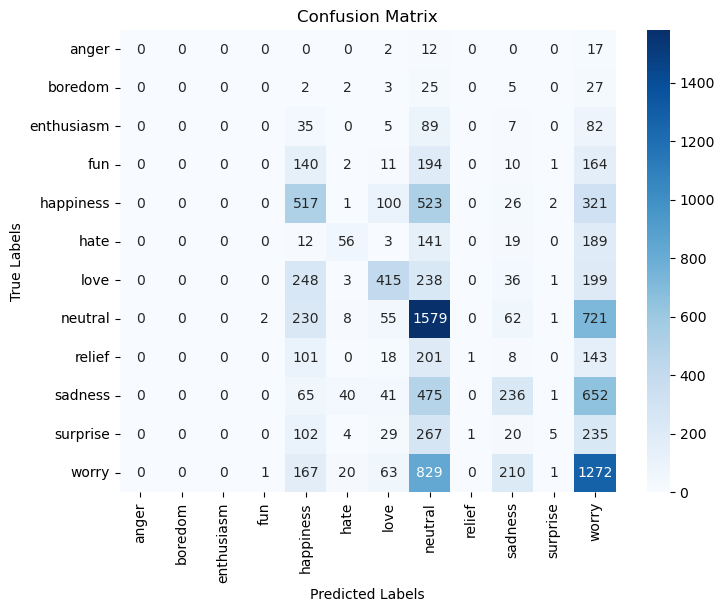

In [31]:
from sklearn.metrics import confusion_matrix

X_train_cv_sample = X_train_cv[:10000]
y_resampled_1d_sample = y_resampled_1d[:10000]

print("training svm...")
svm_classifier_cv = SVC() # I create the classifier
svm_classifier_cv.fit(X_train_cv_sample, y_resampled_1d_sample) # I train the classifier
print("training complete")

print("predicting...")
svm_pred_cv = svm_classifier_cv.predict(X_test_cv) # I make prediction on test set
print("prediction complete")

# I evaluate the model
print("evaluating \n")
print("Accuracy:", accuracy_score(y_test, svm_pred_cv))
print("\nClassification Report:\n", classification_report(y_test, svm_pred_cv))
confusion_matrix_svm = confusion_matrix(y_test, svm_pred_cv)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier_cv.classes_, yticklabels=svm_classifier_cv.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
#knn_classifier_cv = KNeighborsClassifier() # I create the classifier
#knn_classifier_cv.fit(X_train_cv_sample, y_resampled_1d_sample) # I train the classifier

#knn_pred_cv = knn_classifier_cv.predict(X_test_cv) # I make prediction on test set

# I evaluate the model
#print("Accuracy:", accuracy_score(y_test, knn_pred_cv))
#print("\nClassification Report:\n", classification_report(y_test, knn_pred_cv))

training RF...
training complete
predicting...
prediction complete
evaluating... 

Random Forest Classifier:
Accuracy: 0.30652710407624884

Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        31
     boredom       0.00      0.00      0.00        64
  enthusiasm       0.00      0.00      0.00       218
         fun       0.16      0.07      0.09       522
   happiness       0.26      0.25      0.26      1490
        hate       0.20      0.10      0.14       420
        love       0.42      0.40      0.41      1140
     neutral       0.33      0.53      0.40      2658
      relief       0.21      0.05      0.08       472
     sadness       0.27      0.26      0.27      1510
    surprise       0.15      0.06      0.08       663
       worry       0.32      0.32      0.32      2563

    accuracy                           0.31     11751
   macro avg       0.19      0.17      0.17     11751
weighted avg       0.28 

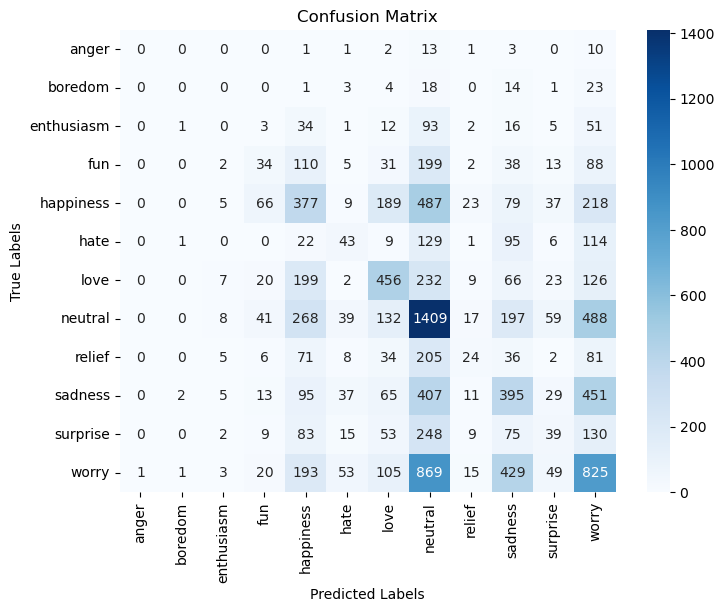

In [33]:
print("training RF...")
rf_classifier_cv = RandomForestClassifier(n_estimators=120, random_state=42) # I create the classifier
rf_classifier_cv.fit(X_train_cv_sample, y_resampled_1d_sample)
print("training complete")

print("predicting...")
rf_pred_cv = rf_classifier_cv.predict(X_test_cv) # I make prediction on test set
print("prediction complete")

print("evaluating... \n")
# Evaluate the Random Forest classifier
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_pred_cv))
print("\nClassification Report:\n", classification_report(y_test, rf_pred_cv))
confusion_matrix_rf = confusion_matrix(y_test, rf_pred_cv)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier_cv.classes_, yticklabels=rf_classifier_cv.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br>I have tried different sample sizes & both vectorizers, the best performing looking at accuracy only is SVM with Count Vectorizer.
<br>It can increase up to 36% of accuracy when using the entire dataset instead of sample but it takes more time to run.
<br>I'll do a cost & benefit analysis using Count Vectorizer with SVM & Random Forest algorithm.
</div>

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br>We have to imagine a business value to apply a cost & benefit analysis.
<br>Considering a marketing company, we can use sentiment analysis to run targeted campaigns on social media (and improves its effectiveness).
<br>For example, if I'm a company selling subscription to a meditation app, I could be interested to target users that feel worried.
</div>

In [34]:
#I start by defining the cost:
cost_true_positive = -1 #user properly targetted will potentially buy the product
cost_false_positive = 10 #users not targetted properly, loss of money
cost_true_negative = 0 #user targetted properly, avoid spending money for no conversion
cost_false_negative = 5 #users not targetted properly, potential customer missed

In [35]:
#I define what area in the confusion matrix refers to what category (TP, FP, TN, FN) for visual support

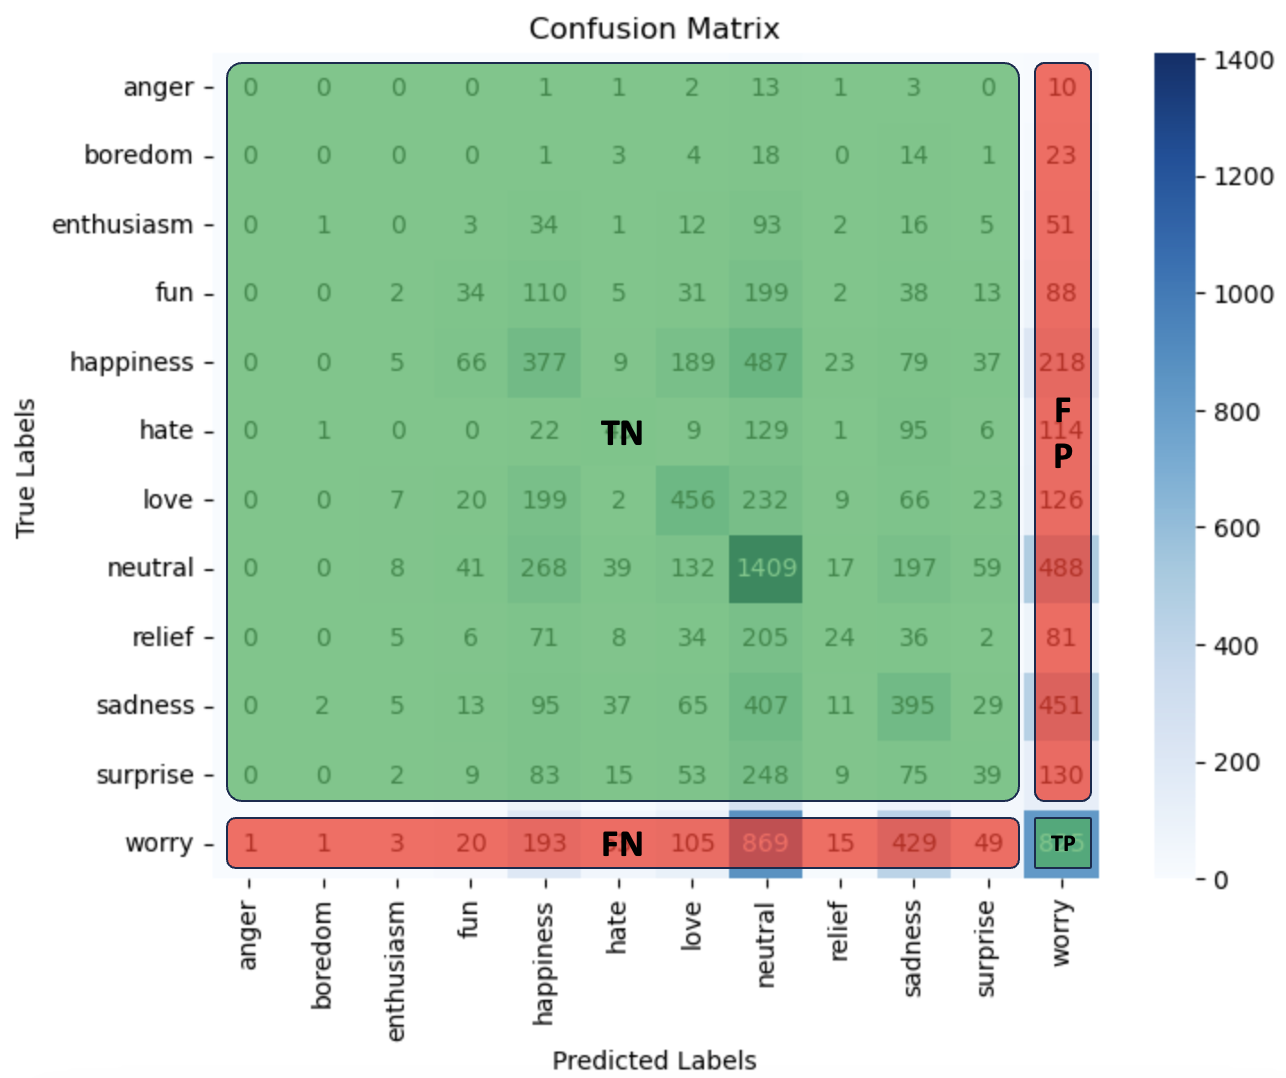

In [36]:
#I multiply those costs with the confusion matrix of both models (focusing on sentiment 'worry').
#This will help me understand which model fits better to my business needs.

#Based on the highlighted areas of the confusion matrix (above), I define a list of true & predicted values
#I'll ignore the TN as I defined a cost of 0 for them.
true_labels = confusion_matrix_rf[-1, :]
predicted_labels = confusion_matrix_rf[:, -1]

#I calculate the cost of each category
TP = true_labels[-1]
FP = np.sum(predicted_labels[:-1])
FN = np.sum(true_labels[:-1])

#I calculate the cost
total_cost = (TP * cost_true_positive) + (FP * cost_false_positive) + (FN * cost_false_negative)

print("Cost & Benefit Analysis for Random Forest model:")
print("TP: ",TP)
print("FP: ",FP)
print("FN: ",FN)
print("Total Cost RF:", total_cost)

Cost & Benefit Analysis for Random Forest model:
TP:  825
FP:  1780
FN:  1738
Total Cost RF: 25665


In [37]:
#I do the same for SVM

true_labels = confusion_matrix_svm[-1, :]
predicted_labels = confusion_matrix_svm[:, -1]

#I calculate the cost of each category
TP = true_labels[-1]
FP = np.sum(predicted_labels[:-1])
FN = np.sum(true_labels[:-1])

#I calculate the cost
total_cost = (TP * cost_true_positive) + (FP * cost_false_positive) + (FN * cost_false_negative)

print("Cost & Benefit Analysis for Support Vector Machine model:")
print("TP: ",TP)
print("FP: ",FP)
print("FN: ",FN)
print("Total Cost SVM:", total_cost)

Cost & Benefit Analysis for Support Vector Machine model:
TP:  1272
FP:  2750
FN:  1291
Total Cost SVM: 32683


<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br>Here is a good example that accuracy is not always relevant depending on the business needs.
<br>In the example I have taken of a targetting marketing compaign, the Random Forest model has a better performance with a cost of 25665 versus a cost of 32683 for Support Vector Machine.
</div>

<div class="alert alert-warning" style="color: red; margin: 10px"><strong>C. Apply a set (at least 3) of clustering algorithms, use clustering quality metrics to evaluate their
quality, and explain the results and what can be learned about the data, describing the clusters obtained in your own words..</strong>
<br> -> In the section below, I'll apply a set of 3 clustering algorithm.
</div>

In [38]:
#I'll start with K-means
from sklearn.cluster import KMeans

#I'll use the count vectorizer as it was performing slightly better with classification models.
#I'll also continue with my X-train set, since it was already pre-processed

#reminder of my training sets
#X_train_cv
#y_resampled_1d

k = 2 #I choose the number of clusters
kmeans = KMeans(n_clusters=k) 
kmeans.fit(X_train_cv) #I fit the model

labels = kmeans.labels_ #I assign labels to a variable for visual check afterwards
print(labels)

/opt/tljh/user/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 1 ... 1 1 1]


In [39]:
#I'll use silhouette score to evaluate the cluster performance
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_train_cv, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.06771394258546226


<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> I've tried several clusters (2,3,5), and the highest score which remain very low (0.06) is with 2 clusters.
<br> This shows a weak structure in the data (1 means clusters are well apart from each other, 0 means clusters are indifferent and -1 means clusters are assigned the wrong way).
</div>

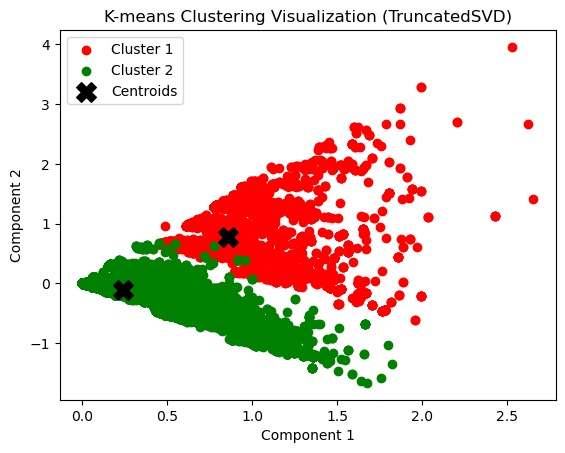

In [40]:
from sklearn.decomposition import TruncatedSVD

# Reduce dimensions for visualization using TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_train_cv)

# Visualize cluster assignments
colors = ['r', 'g', 'b']  # Add more colors if needed
for i in range(k):
    plt.scatter(X_svd[labels == i, 0], X_svd[labels == i, 1], c=colors[i], label=f'Cluster {i + 1}')

# Plot centroids
centroids_svd = svd.transform(kmeans.cluster_centers_)
plt.scatter(centroids_svd[:, 0], centroids_svd[:, 1], marker='X', s=200, c='black', label='Centroids')

plt.title('K-means Clustering Visualization (TruncatedSVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> We can see the clusters are well separated, but their centroids are indeed not well set apart which explains the Silhouette score.
</div>

In [41]:
#I'll print the first rows of each assigned label and look if I find explanation to the clusters created.

result_df = pd.DataFrame(data={'Label': labels}) #I create a new data frame to combine cluster labels with their tweets
result_df = result_df.join(X_train, how='inner') #I join the tweets

print(result_df[result_df['Label']==0].head(10))
print("\n")
print(result_df[result_df['Label']==1].head(10))

     Label                                             tweets
4        0               want trade someon houston ticket one
12       0                 ugh beat stupid song get next rude
13       0  u watch hill london u realis tourtur week week...
25       0  way home n deal w underag girl drink gin da bu...
49       0                                     wnna take bath
67       0         fell asleep beach put enough sunscreen lol
71       0  woman transfer first impress sexual matern ont...
76       0                                        neither elp
136      0                  cross caus stuck twiddl thumb ugh
171      0  hate chang cours fan life oh met rob someth we...


    Label                                             tweets
1       1             layin n bed headach ughhhh waitin call
2       1                       funer ceremoni gloomi friday
3       1                              want hang friend soon
6       1  sleep im think old friend want he marri damn w...
9       1  

<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> I unfortunately cannot find any obvious explanation to the clusters created.
</div>

In [42]:
#I'll continue with second model, Latent Dirichlet Allocation which is a topic modeling algorithm

from sklearn.decomposition import LatentDirichletAllocation

#I define number of topics & words per topics after couple of trials
no_topics = 10
no_words_per_topic = 10

#I create the model (using code from lecture)
lda = LatentDirichletAllocation(
    n_components=no_topics,
    max_iter=20,
    learning_method='online',
    doc_topic_prior=0.2,
    topic_word_prior=0.2,
    random_state=0)

lda.fit(X_train_cv) #I train the model
print("Complete")

Complete


In [43]:
#Printing the topics

#Using code from the lecture
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}: {', '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])}")

feature_names = count_vectorizer.get_feature_names_out() #Get feature names from the vectorizer
display_topics(lda, feature_names , no_words_per_topic) #Display topics using the function

Topic #1: work, go, new, week, today, home, tonight, next, sorri, sad
Topic #2: got, night, much, wait, great, last, im, sleep, go, final
Topic #3: want, today, make, though, thing, get, girl, guess, cook, he
Topic #4: come, wish, way, weekend, could, play, go, long, wow, thought
Topic #5: thank, ever, tweet, rain, damn, man, sure, may, book, yet
Topic #6: time, miss, hope, good, watch, see, back, fun, lol, love
Topic #7: good, like, look, that, right, bad, tri, feel, even, guy
Topic #8: need, would, show, wanna, sit, bit, stay, parti, everi, boo
Topic #9: day, happi, mother, hate, tomorrow, bed, mom, live, year, best
Topic #10: get, realli, know, think, go, still, work, bore, im, feel


<div class="alert alert-info" style="margin: 10px"><strong>Note:</strong>
<br> I'm rather happy with the results, some topics were well found.
<br>   
<br>Topic 1: Work Routine
<br>Topic 2: Excitement
<br>Topic 3: Desire
<br>Topic 4: Weekend Plans
<br>Topic 5: Gratitude
<br>Topic 6: Memories
<br>Topic 7: Opinion & Observation
<br>Topic 8: Desire & Socializing
<br>Topic 9: Mother's Day
<br>Topic 10: Feelings
</div>

In [46]:
#I'll finish with last model, Singular Value Decomposition
#The goal with SVD is to reduce the dimensionality of the data into n components.

from sklearn.decomposition import TruncatedSVD

# I define the quantity of components
n_components = 50

# I apply & train the model
svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(X_train_cv)

/opt/tljh/user/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


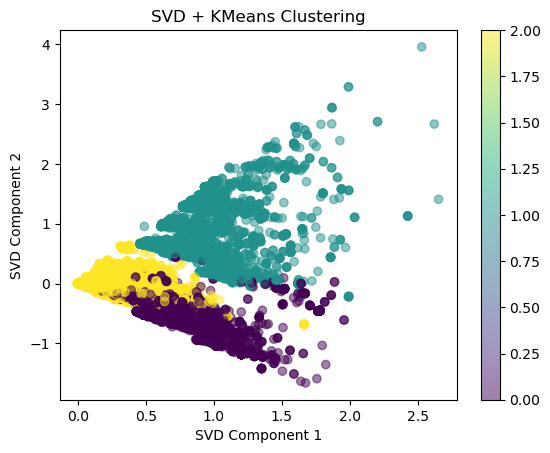

In [51]:
# I'll now use the SVD results to assign clusters

n_clusters = 3  #I defined 3 clusters, as with more it starts to not be well seperated in the visual
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_svd)
labels = kmeans.labels_

# Visualization (2D)
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('SVD + KMeans Clustering')
plt.colorbar()
plt.show()

Notes from professor:; (copied from online university exam platoform)

imbalance is shown.  
Outliers are not enough elaborated, but some unusual cases distinguished.
Missing values are considered.  
Multiple-targets are not discussed.  
Further analyses points are given, but the possibility/quality of making them with the available data is not addressed.  
There charts are used in exploration, good.  
All charts have discussions/interpretations.  
Not much seen for the sake of additional aspects of data.  
Mentioned other analysis points are either not possible or can be done in a very limited way with the data at hand.  
No additional analysis is made.  
Short, but clear explanations.  
Sentiment is selected as suggested in the description document.  
TF-IDF is applied to the test data as well.  
Cross validation is not performed.  
Confusion matrices are plotted.  
No dedicated discussion for any specific error type.  
Cost analysis is done.  
Grade: 8.125/10  